In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
torch.set_default_tensor_type(torch.FloatTensor)
import sys
import os, random

notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)

from rct_data_generator import *
from outcome_models import *
from plotting_functions import *
from mcmc_bayes_update import *
from eig_comp_utils import *
from research_exp_utils import *

### 1. Simulating the data

In [3]:
rng = np.random.RandomState(42)

varying_sample_sizes = [100, 120, 140, 160, 180, 200]
fixed_n_complementary = 100
n_host = 100 
n_host_test = 1000


n_rct_before_split = 10**5
std_true_y = 1
sigma_prior = 1
sigma_rand_error = 1
include_intercept = 1  # 0 if no intercept
power_x, power_x_t = 1, 1

np.random.seed(42)
random.seed(42)

X0 = np.random.beta(12, 3, size=n_rct_before_split)
X1 = np.random.normal(loc=4, scale=1, size=n_rct_before_split)
X2 = np.random.beta(1, 7, size=n_rct_before_split)
x_distributions = {"X_0": X0, "X_1": X1, "X_2": X2}
d = (
    include_intercept
    + len(x_distributions) * (power_x)
    + 1
    + len(x_distributions) * (power_x_t)
)

p_assigned_to_host = lambda X, T, eps: sigmoid(
    1 + 2 * X["X_0"] - X["X_1"] + 2 * T + eps
)
p_assigned_to_cand2 = lambda X, T, eps: sigmoid(
    1 + 2 * X["X_0"] - X["X_1"] + 2 * T + eps
)


causal_param_first_index = power_x*len(x_distributions) + include_intercept 

outcome_function = (
    # y = 1 + 1*X_0 - 1*X_1 + 1*X_2 + 4*T + 2*X_0*T + 2*X_1*T + 0*X_2*T + eps
    lambda X, T, eps: include_intercept  # intercept, non-causal => 0 no intercept
    + 1 * X["X_0"]  # non-causal
    - 1 * X["X_1"]  # non-causal
    + 1 * X["X_2"]  # non-causal
    + 5 * T  # causal
    + 2 * X["X_0"] * T  # causal
    + 2 * X["X_1"] * T  # causal
    - 4 * X["X_2"] * T  # causal
    + eps
)

CATE_function = lambda X: outcome_function(X,np.ones(len(X)), 0 )-outcome_function(X,np.zeros(len(X)),0)

if include_intercept:
    true_params = np.array([1, 1, -1, 1, 5, 2, 2, -4])  # intercept, non-causal => 0
else:
    true_params = np.array([1, -1, 1, 5, 2, 2, -4])  # copied from above
std_true_y = 1  # Standard deviation for the true Y

Simulation parameters

In [4]:
# Prior parameters for Bayesian update on host
if include_intercept:
    prior_mean = np.array([0, 0, 0, 0, 0, 0, 0, 0])
else:
    prior_mean = np.array([0, 0, 0, 0, 0, 0, 0])
assert len(prior_mean) == d, "Shape error"

beta_0, sigma_0_sq, inv_cov_0 = (
    prior_mean,
    sigma_rand_error**2,
    1 / sigma_prior * np.eye(len(prior_mean)),
)
prior_hyperparameters = {
    "beta_0": beta_0,
    "sigma_0_sq": sigma_0_sq,
    "inv_cov_0": inv_cov_0,
}


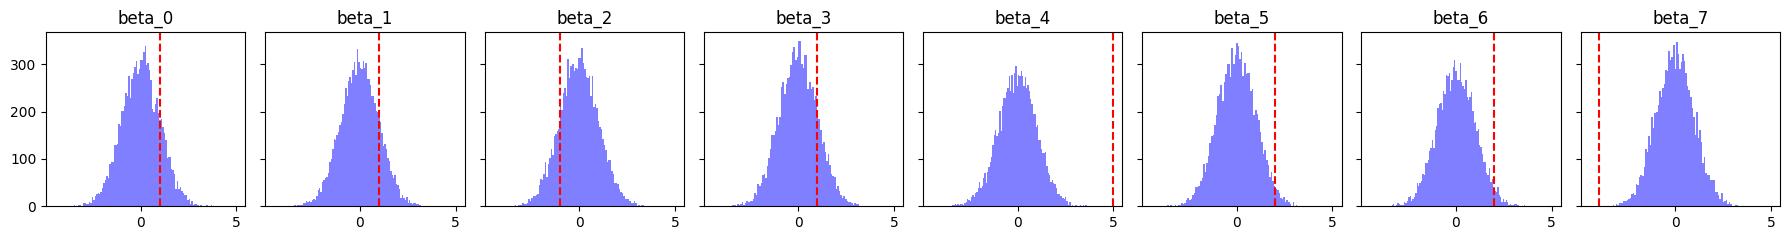

In [5]:
# sample from the prior:
beta_samples = rng.multivariate_normal(
    prior_mean, cov=sigma_prior * np.eye(len(prior_mean)), size=10000
)
# plot the prior samples and true_params as red crosses:
# let's do d subplots
ax, fig = plt.subplots(1, d, figsize=(18, 2.5), sharex=True, sharey=True)

# on each subplot, plot the prior samples and the true params
for i in range(d):
    fig[i].hist(beta_samples[:, i], bins=100, alpha=0.5, color="blue")
    fig[i].axvline(true_params[i], color="red", linestyle="--")
    fig[i].set_title(f"beta_{i}")

plt.tight_layout()
plt.show()

In [6]:
n_seeds = 50
data_parameters = {
    "fixed_n_complementary": fixed_n_complementary,
    "varying_sample_sizes": varying_sample_sizes,
    "n_rct_before_split": n_rct_before_split,
    "x_distributions": x_distributions,
    "p_assigned_to_cand2": p_assigned_to_cand2,
    "p_assigned_to_host": p_assigned_to_host,
    "n_host_test_included": n_host+n_host_test,
    "power_x": power_x,
    "power_x_t": power_x_t,
    "outcome_function": outcome_function,
    "std_true_y": std_true_y,
    "causal_param_first_index": causal_param_first_index,
}

### 2. EIG closed form 

In [7]:
EIG_obs_closed_form_across_seeds, EIG_caus_closed_form_across_seeds = [], []
all_seeds_data = {}
all_seeds_host_data_test = {i:{} for i in range (n_seeds)}

for seed in range(n_seeds):
    one_seed_data = generate_data_varying_sample_size(
        data_parameters, include_intercept=bool(include_intercept), seed=i)
    all_seeds_data[seed] = one_seed_data
    for sample_size in varying_sample_sizes:
        test_and_train_host = all_seeds_data[seed][sample_size]['host']
        all_seeds_data[seed][sample_size]['host'] = test_and_train_host.iloc[:n_host,:]
        all_seeds_host_data_test[seed][sample_size] = test_and_train_host.iloc[n_host:,:]

for seed in range(n_seeds):
    EIGs = linear_eig_closed_form_varying_sample_size(  
        all_seeds_data[seed],
        data_parameters,
        prior_hyperparameters,
        verbose=False,
    )
    EIG_obs_closed_form_across_seeds.append(
        [cand_values for cand_values in EIGs[0].values()]
    )
    EIG_caus_closed_form_across_seeds.append(
        [cand_values for cand_values in EIGs[1].values()]
    )

EIG_obs_closed_form_across_seeds = np.vstack(EIG_obs_closed_form_across_seeds)  
EIG_caus_closed_form_across_seeds = np.vstack(EIG_caus_closed_form_across_seeds)


In [8]:
proportions = np.array(varying_sample_sizes)/fixed_n_complementary
proportions

array([1. , 1.2, 1.4, 1.6, 1.8, 2. ])

### 2. EIG from samples for varying sample sizes

In [9]:
n_samples_outer_expectation_obs = 400
n_samples_inner_expectation_obs = 800
n_samples_outer_expectation_caus = 400
n_samples_inner_expectation_caus = 800

sampling_parameters = {
    "n_samples_inner_expectation_obs": n_samples_inner_expectation_obs,
    "n_samples_outer_expectation_obs": n_samples_outer_expectation_obs,
    "n_samples_inner_expectation_caus": n_samples_inner_expectation_caus,
    "n_samples_outer_expectation_caus": n_samples_outer_expectation_caus,
}

In [10]:
sample_sizes = data_parameters["varying_sample_sizes"]
candidates_names = all_seeds_data[0][sample_sizes[0]].keys() - ["host"]

In [ ]:
EIG_obs_samples_across_seeds, EIG_caus_samples_across_seeds = [], []

EIGs = linear_eig_from_samples_varying_sample_size(
    all_seeds_data[i], data_parameters, prior_hyperparameters, sampling_parameters
)
EIG_obs_samples_across_seeds.append(
    [cand_values for cand_values in EIGs[0].values()]
)
EIG_caus_samples_across_seeds.append(
    [cand_values for cand_values in EIGs[1].values()]
)

EIG_obs_samples_across_seeds = np.vstack(EIG_obs_samples_across_seeds)  
EIG_caus_samples_across_seeds = np.vstack(EIG_caus_samples_across_seeds)


In [ ]:
verbose = True

sample_sizes = data_parameters["varying_sample_sizes"]
candidates_names = data[sample_sizes[0]].keys() - ["host"]
(
    n_samples_outer_expectation_obs,
    n_samples_inner_expectation_obs,
    n_samples_inner_expectation_caus,
    n_samples_outer_expectation_caus,
) = (
    sampling_parameters["n_samples_outer_expectation_obs"],
    sampling_parameters["n_samples_inner_expectation_obs"],
    sampling_parameters["n_samples_inner_expectation_caus"],
    sampling_parameters["n_samples_outer_expectation_caus"],
)

# dict of the form {candidate_name: {sample_size: EIG}}
EIG_obs = {name: [] for name in candidates_names}
EIG_caus = {name: [] for name in candidates_names}

for length in sample_sizes:
    dlen = data[length]  # for convenience
    bayes_reg = BayesianLinearRegression(prior_hyperparameters)
    bayes_reg.set_causal_index(data_parameters["causal_param_first_index"])

    ### Bayesian update on host data using closed form
    X_host = torch.from_numpy(dlen["host"].drop(columns=["Y"]).values)
    Y_host = torch.from_numpy(dlen["host"]["Y"].values)
    # fit the posterior (updates the params in the model class)
    bayes_reg.fit(X_host, Y_host)
    

    if verbose:
        print(f"For a sample size of {length}")
        print(f" % treated in host: {int(100 * dlen['host']['T'].mean())}%")

    for cand in candidates_names:
        X_cand = torch.from_numpy(dlen[cand].drop(columns=["Y"]).values)
        if verbose:
            print(f" % treated in {cand}: {int(100 * dlen[cand]['T'].mean())}%")

        EIG_obs[cand].append(bayes_reg.samples_obs_EIG(
            X_cand, n_samples_outer_expectation_obs, n_samples_inner_expectation_obs))
        
        EIG_caus[cand].append(bayes_reg.samples_causal_EIG(
            X_cand, n_samples_outer_expectation_caus, n_samples_inner_expectation_caus))

### Ground truth : merging and fit Y

In [13]:
merged_datasets = {i:{} for i in range (len(all_seeds_data.keys()))}
CATE_function = lambda X: outcome_function(X,np.ones(len(X)), 0 )-outcome_function(X,np.zeros(len(X)),0)

for seed, seed_data_dict in all_seeds_data.items():
    for sample_size, data_dict in seed_data_dict.items():
        merged_data_dict={}
        for name, data in data_dict.items():
            if name != 'host':
                merged_data_dict[name]= pd.concat([data_dict['host'], data_dict[name]], axis=0)
        merged_datasets[seed][sample_size] = merged_data_dict

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


merged_mse = {sample_size:{'complementary':[], 'cand2':[],'complementary_CATE':[], 'cand2_CATE':[]} for sample_size in varying_sample_sizes}

for seed, seed_data_dict in merged_datasets.items():
    for sample_size, data_dict in seed_data_dict.items():  
        for cand_name, data in data_dict.items():

            host= all_seeds_data[seed][sample_size]['host']
            XandT_host, Y_host = host.drop(columns=['Y']), host['Y']

            X, Y = data.drop(columns=['Y']), data['Y']
            model = LinearRegression() #change to ridge with fit intercept ridge param is 1
            model.fit(X,Y)

            Y_pred = model.predict(X)
            mse = mean_squared_error(Y, Y_pred) # mse y model fitted on merged # not used
            merged_mse[sample_size][cand_name].append(mse) 
            
            XandT_host_test = all_seeds_host_data_test[i][sample_size].drop(columns=['Y'])
            true_cate = CATE_function(XandT_host_test.drop(columns=['T']))

            X_zero = XandT_host_test.copy()
            X_zero.iloc[:,4:] = 0
            X_one = XandT_host_test.copy()
            X_one.iloc[:,4:] = XandT_host_test.iloc[:,:4]

            pred_cate = model.predict(X_one) - model.predict(X_zero)
            mse_CATE = mean_squared_error(true_cate, pred_cate)
            merged_mse[sample_size][cand_name+"_CATE"].append(mse_CATE)


mean_mse = {"pred":[],"CATE":[]}

for seed, seed_data_dict in merged_mse.items():
    mse_array = pd.DataFrame.from_dict(seed_data_dict).values
    mse_array_pred = mse_array[:,0] - mse_array[:,1] # complementary - twin <0: Error(twin) > Error(complementary) for n_twin > n_complementary
    mse_array_CATE = mse_array[:,2] - mse_array[:,3] # complementary - twin <0: Error(twin) > Error(complementary) for n_twin > n_complementary
    mean_mse['pred'].append(np.mean(mse_array_pred))
    mean_mse['CATE'].append(np.mean(mse_array_CATE))

In [ ]:
# in case one wants to fetch the results directly

In [ ]:
predictive_mcmc = pd.read_csv("./data_for_plots/linear_synthetic/predictive_mcmc.csv")
predictive_closed_form = pd.read_csv("./data_for_plots/linear_synthetic/obs_closed_form.csv")
caus_mcmc = pd.read_csv("./data_for_plots/linear_synthetic/caus_mcmc.csv")
caus_closed_form = pd.read_csv("./data_for_plots/linear_synthetic/caus_closed_form.csv")

mean_mse_cate = pd.read_csv("./data_for_plots/linear_synthetic/mean_mse_cate.csv")

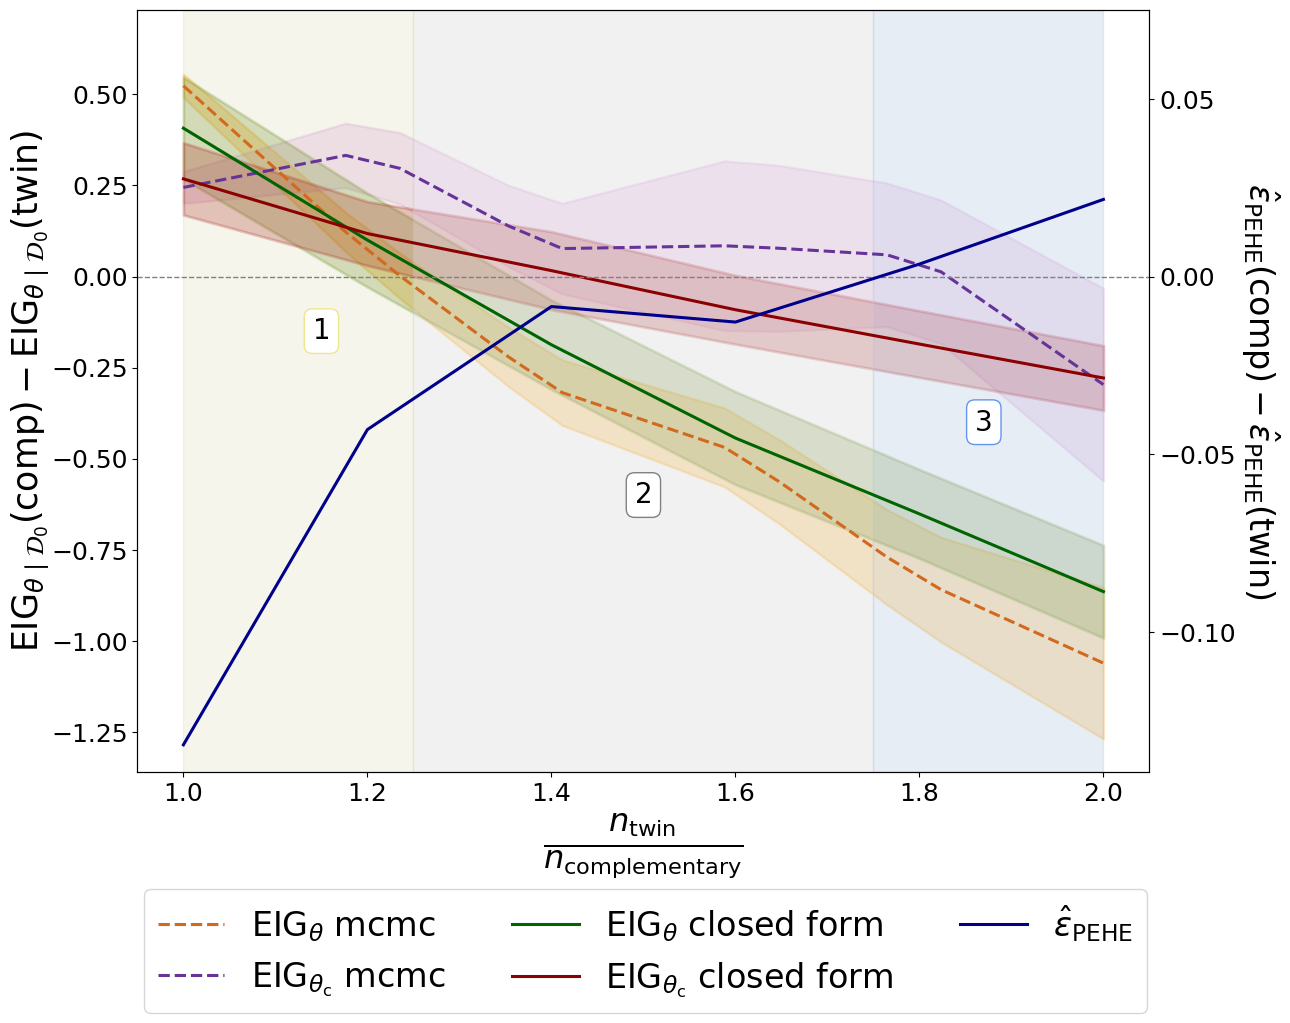

In [40]:
dict_all_diff = {r'$\mathrm{EIG}_{\theta}$'+' mcmc': predictive_mcmc, r'$\mathrm{EIG}_{\theta_{\text{c}}}$'+' mcmc': caus_mcmc, \
                 r'$\mathrm{EIG}_{\theta}$'+' closed form': predictive_closed_form, r'$\mathrm{EIG}_{\theta_{\text{c}}}$'+' closed form': caus_closed_form}
std_color_dict = {r'$\mathrm{EIG}_{\theta}$'+' mcmc': 'orange', r'$\mathrm{EIG}_{\theta_{\text{c}}}$'+' mcmc': 'plum', \
                 r'$\mathrm{EIG}_{\theta}$'+' closed form': 'olivedrab', r'$\mathrm{EIG}_{\theta_{\text{c}}}$'+' closed form': 'firebrick'}
mean_color_dict = {r'$\mathrm{EIG}_{\theta}$'+' mcmc': 'chocolate', r'$\mathrm{EIG}_{\theta_{\text{c}}}$'+' mcmc': 'rebeccapurple', \
                 r'$\mathrm{EIG}_{\theta}$'+' closed form': 'darkgreen', r'$\mathrm{EIG}_{\theta_{\text{c}}}$'+' closed form': 'darkred'}
axis_names = [r'$\frac{n_{twin}}{n_{complementary}}$', 
                r'$\mathrm{EIG}_{\theta \mid \mathcal{D_{\text{comp}}} - \mathrm{EIG}_{\theta \mid \mathcal{D_{\text{twin}}}}$', 
                r'$\hat{\epsilon}_{\text{PEHE}}(\text{comp})-\hat{\epsilon}_{\text{PEHE}}(\text{twin})$']
axis_names = [r'$\frac{n_{\text{twin}}}{n_{\text{complementary}}}$', 
              r'$\mathrm{EIG}_{\theta \mid \mathcal{D}_0}(\text{comp}) - \mathrm{EIG}_{\theta \mid \mathcal{D}_0}(\text{twin})$', 
              r'$\hat{\epsilon}_{\text{PEHE}}(\text{comp}) - \hat{\epsilon}_{\text{PEHE}}(\text{twin})$']


plot_dict(
    x = proportions,
    data_dict = dict_all_diff,
    mean_color_dict= mean_color_dict,
    std_color_dict = std_color_dict,
    axis_names=axis_names,
    dict_additional_plots=None,
    text=None,
    title= None,
    second_axis={r'$\hat{\epsilon}_{\text{PEHE}}$':mean_mse_cate},
    save = "/Users/lucile/causal_info_gain/plots/linear_synthetic/with_text_box") #"/Users/lucile/causal_info_gain/plots/linear_synthetic/without_text_box")
